# French Text Processing and Classification with TensorFlow and Hugging Face

This notebook demonstrates a comprehensive process of loading, preprocessing, and preparing a French text dataset for a classification task using TensorFlow and Hugging Face's transformers.



# 1. Setup and Imports
- `pandas`: For data manipulation and analysis.
- `transformers`: Provides access to Hugging Face's CamembertTokenizer and AutoTokenizer for text tokenization.
- `tensorflow`: An open-source library for various machine learning tasks.
- `re`: Regular expression operations for text processing.
- `spacy`: Advanced Natural Language Processing in Python.
- `sklearn.model_selection`: Provides train_test_split function for splitting the dataset.
- `sklearn.preprocessing`: LabelEncoder for encoding labels.
- Additional libraries such as `numpy` are imported.
- We import various classes from Keras, including layers for building the model and tools for compiling and training it.

## Package Installation

In [1]:
!pip install datasets
!pip install accelerate -U
!pip install sentencepiece sacremoses
!pip install evaluate
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.0 MB/s eta 0:00:00
2023-12-19 22:35:56.764806: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 22:35:56.764874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12

## Python Library Imports

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import spacy
import evaluate
import torch
import joblib
import keras

## Imports from Specific Libraries

In [3]:
from transformers import CamembertTokenizer, AutoTokenizer, TFAutoModel, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from datasets import Dataset
from google.colab import drive
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import RMSprop
from keras import Model, layers
from keras import Input


## Mount Google Drive (specific to Google Colab)

In [4]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


## Model Loading

In [5]:
nlp = spacy.load('fr_core_news_sm')

# 2. Data Loading and Preprocessing


## Load the Datasets
- The dataset is loaded from a CSV file into a pandas DataFrame.

In [6]:
# Load the dataset
file_path = 'https://raw.githubusercontent.com/DalipiDenis/machine-learning-project-Hublot/main/datasets/training_data.csv'
data = pd.read_csv(file_path)

## Initial Data Inspection
- The first few rows of the dataset are displayed using `data.head()` for a quick overview.

In [7]:
# Display the first few rows of the training dataset
print("Training Dataset:")
print(data.head())

Training Dataset:
   id                                           sentence difficulty
0   0  Les coûts kilométriques réels peuvent diverger...         C1
1   1  Le bleu, c'est ma couleur préférée mais je n'a...         A1
2   2  Le test de niveau en français est sur le site ...         A1
3   3           Est-ce que ton mari est aussi de Boston?         A1
4   4  Dans les écoles de commerce, dans les couloirs...         B1


## Data Preprocessing

In [8]:
# Rename columns and drop unnecessary ones in the training dataset
data = data.rename(columns={'sentence': 'text', 'difficulty': 'labels'}).drop(['id'],axis=1)

## Data Cleaning Function
- The dataset is renamed for clarity, changing 'sentence' to 'text' and 'difficulty' to 'labels'.
- Unnecessary columns like 'id' are dropped.
- A custom function `initial_clean` is defined for basic text cleaning which includes:
    - Lowercasing the text.
    - Removing non-alphabetic characters.
- The `initial_clean` function is applied to the 'text' column.

In [9]:
def initial_clean(text):
    text = text.lower()
    text = re.sub(r'[^a-zàâçéèêëîïôûùüÿñæœ]', ' ', text)
    return text

In [10]:
# Apply the cleaning function to the text column of both datasets
data['text'] = data['text'].apply(initial_clean)

## Label Encoding
- A LabelEncoder instance is created and used to encode the 'labels' column.

In [11]:
# Initialize and apply LabelEncoder to transform textual labels into numerical labels
LE = LabelEncoder()
data['labels'] = LE.fit_transform(data['labels'])

# 3. Tokenization and Dataset Preparation

In this section, we focus on tokenizing our text data, preparing it for input into machine learning models. Tokenization is a crucial step in text processing, especially when dealing with languages like French.

## Importing the Tokenizer
- We use the `AutoTokenizer` from the Hugging Face `transformers` library.
- `AutoTokenizer` automatically detects and loads the tokenizer that corresponds to the "camembert-base" model.
- The "camembert-base" model is specifically designed for the French language, making it an ideal choice for our dataset.

## Tokenization Function
- We define a function named `tokenize_function`.
- This function takes examples (text data) and returns tokenized output.
- In the tokenization process, we ensure:
    - Padding is applied to each text so that all texts are of the same length, which is crucial for batch processing in neural networks.
    - Truncation is also applied to limit the length of the texts, ensuring consistent and manageable input sizes.

## Applying Tokenization to the Datasets
- We apply the `tokenize_function` to both our training and validation datasets.
- `train_dataset.map(tokenize_function, batched=True)` processes the training dataset.
- `val_dataset.map(tokenize_function, batched=True)` processes the validation dataset.
- The `batched=True` argument in the `map` function ensures that tokenization is applied in batches, making the process more efficient.

This tokenization step is essential for preparing the dataset for training and evaluating language models, ensuring uniformity and consistency in the input data.


## Split Training Data

In [12]:
# Split the training data into training and validation sets
train_data,val_data = train_test_split(data, test_size=0.2)

## Convert to Dataset Objects

In [13]:
# Convert the training and validation data into Dataset objects
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

## Initialize Tokenizer

In [14]:
# Initialize the tokenizer for the Camembert model
tokenizer = AutoTokenizer.from_pretrained("camembert-base")

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

## Tokenization Function

In [15]:
# Define a function to tokenize the text
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

## Apply Tokenization

In [16]:
# Apply the tokenization function to the training and validation datasets
traintokenized_datasets = train_dataset.map(tokenize_function, batched=True)

valtokenized_datasets = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3840 [00:00<?, ? examples/s]

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

# 4. Model Setup and Training


## Model Initialization

In [17]:
# Initialize the model for sequence classification
bmodel = AutoModelForSequenceClassification.from_pretrained("camembert-base", num_labels=6)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training Arguments

In [18]:
# Set up the training arguments
training_args = TrainingArguments(output_dir="test_trainer")

## Load Metric for Evaluation

In [19]:
# Load the accuracy metric for model evaluation
metric = evaluate.load("accuracy")

## Training Setup for Language Model with Custom Metrics

In this part of the notebook, we set up the training configuration for our language model using the Hugging Face `transformers` library. This involves defining a custom metric for evaluation and configuring the training arguments.

## Defining the Compute Metrics Function
- We define a function named `compute_metrics` for evaluating our model.
- This function takes `eval_pred` as input, which contains the model's logits and the true labels.
- It calculates the predictions by applying the `np.argmax` function to the logits, effectively choosing the most likely class.
- Finally, the function returns the computed metrics, which will be based on the predictions and the true labels.

## Setting Up Training Arguments
- We use the `TrainingArguments` class to specify our training configuration.
- `output_dir="test_trainer"`: Specifies the directory where the training outputs (like model checkpoints) will be saved.
- `num_train_epochs=19`: Sets the number of training epochs to 19.
- `evaluation_strategy="epoch"`: Determines that evaluation will be performed at the end of each epoch.

## Initializing the Trainer
- The `Trainer` class is initialized with several key components:
    - `model=bmodel`: The model to be trained, represented here as `bmodel`.
    - `args=training_args`: The training arguments defined earlier.
    - `train_dataset=traintokenized_datasets`: The tokenized training dataset.
    - `eval_dataset=valtokenized_datasets`: The tokenized validation dataset.
    - `compute_metrics=compute_metrics`: The custom metric computation function defined earlier.

This setup is crucial for training our model effectively, ensuring that it is evaluated correctly at each epoch and that the results are stored for further analysis.


In [20]:
# Define a function to compute metrics (e.g., accuracy)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(output_dir="test_trainer",num_train_epochs=19, evaluation_strategy="epoch")

# Set up the Trainer
trainer = Trainer(
    model=bmodel,
    args=training_args,
    train_dataset=traintokenized_datasets,
    eval_dataset=valtokenized_datasets,
    compute_metrics=compute_metrics,
)

## Model Training

In [21]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.104858,0.508333
2,1.276000,1.172930,0.512500
3,0.933800,1.111441,0.581250
4,0.704200,1.424406,0.561458
5,0.472200,1.774803,0.552083
6,0.333800,2.167024,0.556250
7,0.243600,2.624218,0.539583
8,0.179800,2.862916,0.552083
9,0.111700,2.995971,0.555208
10,0.091000,2.908787,0.570833


TrainOutput(global_step=9120, training_loss=0.25462946613368237, metrics={'train_runtime': 2567.6741, 'train_samples_per_second': 28.415, 'train_steps_per_second': 3.552, 'total_flos': 1.919727203254272e+16, 'train_loss': 0.25462946613368237, 'epoch': 19.0})

## Saving the Trained Model
In this section of the notebook, we focus on saving the trained model, reloading it for further use, and extracting additional linguistic features from the text data.

- We use the `save_model` method of the `Trainer` object to save the fine-tuned model.
- The model is saved to the directory `/content/cambert_french_finetuned/`.
- Saving the model allows us to reuse it later without needing to retrain it.

In [22]:
# Save the trained model
trainer.save_model("/content/cambert_french_finetuned/")

## Model Loading
- We use `AutoModelForSequenceClassification` from Hugging Face's `transformers` library to load the saved model.
- The model is loaded from the previously saved directory.
- `num_labels=6` specifies that the model is used for a classification task with 6 different classes.

In [23]:
bmodel = AutoModelForSequenceClassification.from_pretrained("/content/cambert_french_finetuned/", num_labels=6)

# 5. Feature Engineering and Embeddings


## POS Tagging Function
- We define a function `get_pos_tags` to extract Part-of-Speech (POS) tags from the text.
- This function uses the `spacy` library to process the text and return POS tags for each token.
- The `get_pos_tags` function is applied to the 'text' column of our DataFrame, creating a new column `pos_tags` that contains the POS tags for each text entry.


In [24]:
# Define a function to extract POS tags using Spacy
def get_pos_tags(text):
    doc = nlp(text)
    return [token.pos_ for token in doc]

## Apply POS Tagging

In [25]:
# Apply the POS tagging function to the dataset
data['pos_tags'] = data['text'].apply(get_pos_tags)

## One-Hot Encoding of POS Tags
- We gather all unique POS tags present in our dataset.
- A one-hot encoding approach is used to represent these POS tags numerically.
- This process involves creating vectors where each vector corresponds to a text entry.
- In each vector, a '1' represents the presence of a specific POS tag, and a '0' represents its absence.
- These one-hot encoded vectors provide a useful feature set for machine learning tasks, enabling models to understand the syntactic structure of the text.

In [26]:
# Get unique POS tags in the entire DataFrame
all_pos_tags = set(tag for tags in data['pos_tags'] for tag in tags)

# Create a one-hot encoded matrix for POS tags
one_hot_vectors = []
for tags in data['pos_tags']:
    vector = [1 if pos_tag in tags else 0 for pos_tag in all_pos_tags]
    one_hot_vectors.append(vector)

# Convert the list of one-hot vectors into a DataFrame
pos_tags_df = pd.DataFrame(one_hot_vectors, columns=list(all_pos_tags))

# Concatenate the POS tags DataFrame with your original DataFrame
df = pd.concat([data, pos_tags_df], axis=1)

In [27]:
bmodel.cuda()

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

# 6. Generating BERT Embeddings for Text Analysis

This section of the notebook demonstrates how to generate BERT embeddings for text data, an essential step in leveraging the power of pre-trained language models for advanced text analysis.

## Function to Get BERT Embeddings
- We define a function `get_bert_embeddings` which takes a text input and returns its BERT embeddings.
- The function uses the `tokenizer` to tokenize and encode the text input.
    - `return_tensors='pt'` specifies that the output will be PyTorch tensors.
    - Padding and truncation are applied to handle texts of varying lengths.
- The encoded input is then moved to a CUDA device (GPU) for faster processing.
- The model (`bmodel`) processes the encoded text without gradient calculations (`torch.no_grad()`) for efficiency.
- The function extracts the last hidden states from the model's output and applies mean pooling.
- The pooled output is then moved back to the CPU and converted to a NumPy array for compatibility with other Python libraries like scikit-learn.

## Batch Processing of Text Data
- We divide our DataFrame's text data into batches of size 8 using list comprehension.
- For each batch, the `get_bert_embeddings` function is called to generate embeddings.
- These embeddings are collected in a list.

## Concatenating Embeddings
- After processing all batches, we concatenate the embeddings into a single NumPy array.
- This array can be used as input for various machine learning tasks, providing a rich representation of the text data.

## Flatten and Integrate Embeddings into DataFrame
- The final embeddings can be assigned to the DataFrame for further analysis or modeling.
- This step is currently commented out but can be activated by removing the comment mark.

By converting text data into BERT embeddings, we can capture the contextual nuances of language, which enhances the performance of machine learning models on tasks like classification, sentiment analysis, or feature extraction.


## Embedding Extraction

In [28]:
def get_bert_embeddings(text):
    # Tokenize and encode the text
    embeddings = []
    encoded_input =tokenizer(text, return_tensors='pt',padding="max_length", max_length=512,truncation=True)

    # Move encoded input to the device
    encoded_input = {key: value.to('cuda') for key, value in encoded_input.items()}

    # Get model output and extract the last hidden states
    with torch.no_grad():
        output = bmodel(**encoded_input,output_hidden_states=True)
        # print(output.keys())
    # Mean pooling
    return output.hidden_states[-1].mean(dim=1).squeeze().cpu().numpy()

## Batch Processing of Text Data

In [29]:
# Define the batch size for processing
batch_size=8

# Split the dataset into batches
text_batches = [df['text'][i:i + batch_size] for i in range(0, len(df), batch_size)]

# Initialize an empty list to store the embeddings
embeddings = []

# Process each batch and append the embeddings
for batch in text_batches:
    embeddings.append(get_bert_embeddings(list(batch)))

## Concatenating Embeddings

In [30]:
# Concatenate all the embeddings
embeddings = np.concatenate(embeddings)

## Flatten and Integrate Embeddings into DataFrame

In [31]:
# Reshape the embeddings to a 2D array where each row corresponds to a text
flattened_embeddings = embeddings.reshape((len(df), -1))

# Assign the flattened embeddings to the DataFrame
for i in range(flattened_embeddings.shape[1]):
    df[f'embed_{i}'] = flattened_embeddings[:, i]

<ipython-input-31-0115e1925de3>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'embed_{i}'] = flattened_embeddings[:, i]
<ipython-input-31-0115e1925de3>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'embed_{i}'] = flattened_embeddings[:, i]
<ipython-input-31-0115e1925de3>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame

## Extract Sentence Complexity Features

In [32]:
# Define a function to calculate sentence complexity features
def sentence_features(text):
    words = text.split()
    return len(words), sum(len(word) for word in words) / len(words) if words else 0

# Apply the function to the 'text' column to create new features
df['num_words'], df['avg_word_length'] = zip(*df['text'].apply(sentence_features))

<ipython-input-32-46f8768dab0b>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['num_words'], df['avg_word_length'] = zip(*df['text'].apply(sentence_features))
<ipython-input-32-46f8768dab0b>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['num_words'], df['avg_word_length'] = zip(*df['text'].apply(sentence_features))


# 7. Data Preparation for Modeling Section

## Prepare Feature Matrix and Target Variable

In [33]:
X=df.drop(['text','pos_tags','labels'],axis=1)
y=df['labels']

## Split Data into Training and Testing Sets

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Scale Features (MinMax Scaling)

In [35]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Reshape Data for CNN

In [36]:
X_train_r = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_r = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 8. CNN Model Development
## Building and Training a Convolutional Neural Network with Keras

This section demonstrates the process of building a convolutional neural network (CNN) for text classification using the Keras library. We also set up callbacks for effective training.



## Setting Up Callbacks
- `EarlyStopping`: Stops training when the accuracy metric (`acc`) stops improving, with a patience of 20 epochs.
- `ModelCheckpoint`: Saves the best model based on the validation loss (`val_loss`) to the file `movie_sentiment_m1.h5`.
- `ReduceLROnPlateau`: Reduces the learning rate when a metric has stopped improving, with a factor of 0.1 and a patience of 1 epoch.

## Building the Model
- The model is built using the Keras Functional API.
- `Input` layer: Specifies the shape of the input data.
- `Conv1D` layers: 1D convolutions with 256 filters and a kernel size of 3, using ReLU activation.
- `MaxPooling1D` layers: Reduce the dimensionality of the output from the Conv1D layers.
- `GlobalMaxPooling1D`: Applies global max pooling to the final convolutional layer.
- `Dense` layers: Fully connected layers for classification. The last Dense layer uses softmax activation for multi-class classification.
- The model architecture is summarized using `model.summary()`.

## Compiling the Model
- The model is compiled with the RMSprop optimizer, a learning rate of 0.001, categorical crossentropy loss, and accuracy as the metric.



The model constructed here is specifically designed for text classification tasks, leveraging the strengths of convolutional layers for feature extraction from text data. This setup is suitable for multi-class classification problems, like sentiment analysis.


## Setting Up Callbacks

In [37]:
# Define callbacks
callback_list = [
    keras.callbacks.EarlyStopping(
        patience=20,
        monitor='acc',
    ),

    keras.callbacks.ModelCheckpoint(
        monitor='val_loss',
        save_best_only=True,
        filepath='model/movie_sentiment_m1.h5',
    ),

    keras.callbacks.ReduceLROnPlateau(
        patience=1,
        factor=0.1,
    )
]

## Building the Model

In [38]:
# layer developing
text_input_layer = Input(shape=(X_train_r.shape[1],X_train_r.shape[2],))

text_layer = Conv1D(256, 3, activation='relu')(text_input_layer)
text_layer = MaxPooling1D(3)(text_layer)
text_layer = Conv1D(256, 3, activation='relu')(text_layer)
text_layer = MaxPooling1D(3)(text_layer)
text_layer = Conv1D(256, 3, activation='relu')(text_layer)
text_layer = MaxPooling1D(3)(text_layer)
text_layer = Conv1D(256, 3, activation='relu')(text_layer)
text_layer = MaxPooling1D(3)(text_layer)
text_layer = Conv1D(256, 3, activation='relu')(text_layer)
text_layer = MaxPooling1D(3)(text_layer)
text_layer = GlobalMaxPooling1D()(text_layer)
text_layer = Dense(256, activation='relu')(text_layer)
output_layer = Dense(6, activation='softmax')(text_layer)
model = Model(text_input_layer, output_layer)

## Model Summary

In [39]:
# Print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 787, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 785, 256)          1024      
                                                                 
 max_pooling1d (MaxPooling1  (None, 261, 256)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 259, 256)          196864    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 86, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 84, 256)           196864

## Compiling the Model

In [40]:
# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])

# 9. Model Training and Evaluation
## Training Configuration
- The training process will utilize the callbacks defined earlier for early stopping, model checkpointing, and learning rate reduction.

## One-Hot Encode Target Variables

In [41]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the training labels
y_train=encoder.fit_transform(y_train.values.reshape(-1,1))

# Transform the test labels
y_test=encoder.transform(y_test.values.reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Model Training

In [42]:
# Train the model
history = model.fit(X_train_r, y_train, epochs=50, batch_size=32, callbacks=callback_list,
                    validation_data=(X_test_r, y_test))

Epoch 1/50
120/120 [==============================] - 10s 10ms/step - loss: 1.5882 - acc: 0.3057 - val_loss: 0.8303 - val_acc: 0.8094 - lr: 0.0010
Epoch 2/50
 19/120 [===>..........................] - ETA: 0s - loss: 0.6794 - acc: 0.8388

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - 1s 8ms/step - loss: 0.4459 - acc: 0.8828 - val_loss: 0.6138 - val_acc: 0.8510 - lr: 0.0010
Epoch 3/50
120/120 [==============================] - 1s 7ms/step - loss: 0.3425 - acc: 0.9057 - val_loss: 0.4203 - val_acc: 0.8854 - lr: 0.0010
Epoch 4/50
120/120 [==============================] - 1s 8ms/step - loss: 0.3146 - acc: 0.9174 - val_loss: 0.4104 - val_acc: 0.8802 - lr: 0.0010
Epoch 5/50
120/120 [==============================] - 1s 7ms/step - loss: 0.2854 - acc: 0.9255 - val_loss: 0.4470 - val_acc: 0.8813 - lr: 0.0010
Epoch 6/50
120/120 [==============================] - 1s 7ms/step - loss: 0.2273 - acc: 0.9326 - val_loss: 0.4304 - val_acc: 0.8781 - lr: 1.0000e-04
Epoch 7/50
120/120 [==============================] - 1s 9ms/step - loss: 0.2145 - acc: 0.9375 - val_loss: 0.4220 - val_acc: 0.8792 - lr: 1.0000e-05
Epoch 8/50
120/120 [==============================] - 1s 9ms/step - loss: 0.2117 - acc: 0.9372 - val_loss: 0.4216 - val_acc: 0.8792 -

## Training History Visualization

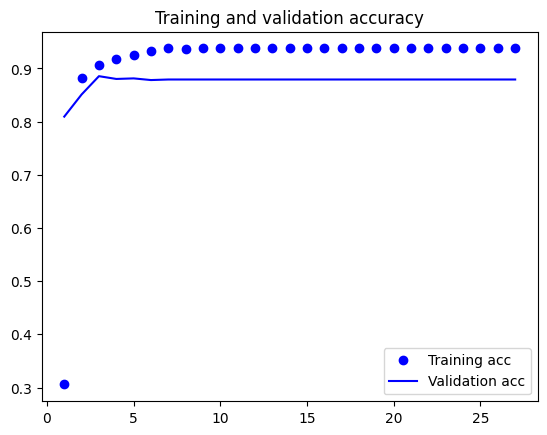

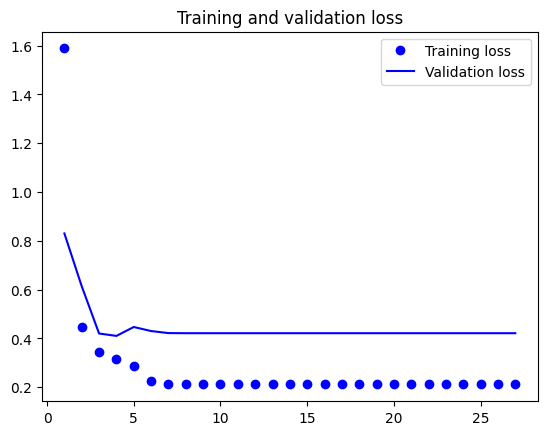

In [43]:
# Plot training & validation accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Detailed Performance Analysis

In [44]:
# Generate predictions
y_pred = model.predict(X_test_r)

# Print classification report
print(classification_report(encoder.inverse_transform(y_test),encoder.inverse_transform( y_pred)))

30/30 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       166
           1       0.85      0.89      0.87       158
           2       0.88      0.89      0.88       166
           3       0.83      0.89      0.86       153
           4       0.85      0.87      0.86       152
           5       0.94      0.82      0.88       165

    accuracy                           0.88       960
   macro avg       0.88      0.88      0.88       960
weighted avg       0.88      0.88      0.88       960



# 10. Predictions
## Extracting and Encoding Part-of-Speech Tags

This section of the notebook demonstrates the process of extracting Part-of-Speech (POS) tags from text data and encoding these tags in a one-hot encoded format, which is a common approach in natural language processing (NLP).

## Defining the POS Tag Extraction Function
- A function `get_pos_tags` is defined to extract POS tags from a given text.
- The function utilizes the `spacy` NLP library to process the text.
- For each token in the text, the function retrieves its POS tag.
- The output is a list of POS tags corresponding to each token in the input text.

## Applying the Function to DataFrame
- The `get_pos_tags` function is applied to each row of the 'text' column in the DataFrame `df`.
- This creates a new column, `pos_tags`, in `df`, where each row contains the POS tags for the corresponding text.

## Extracting Unique POS Tags
- We extract all unique POS tags present across the entire DataFrame.
- This is achieved by creating a set of tags, aggregating tags from all rows in the `pos_tags` column.

## Creating One-Hot Encoded Vectors
- A one-hot encoding approach is used to numerically represent the POS tags.
- For each set of tags in `df['pos_tags']`, a vector is created.
- In each vector, '1' indicates the presence and '0' indicates the absence of a particular POS tag from the set of all unique POS tags.
- These vectors are appended to the list `one_hot_vectors`.

This process of extracting and encoding POS tags is valuable in NLP applications as it converts textual data into a numerical format that can be used for various machine learning models, providing syntactic information about the text.


In [45]:
df=pd.read_csv('https://raw.githubusercontent.com/DalipiDenis/machine-learning-project-Hublot/main/datasets/unlabelled_test_data.csv')

In [46]:
df = df.rename(columns={'sentence': 'text', 'difficulty': 'labels'})
df['text'] = df['text'].apply(initial_clean)

## Applying the Function to DataFrame

In [47]:
# Apply the function to create a new column with POS tags
df['pos_tags'] = df['text'].apply(get_pos_tags)

## Extracting Unique POS Tags

In [48]:
# Get unique POS tags in the entire DataFrame
all_pos_tags = set(tag for tags in data['pos_tags'] for tag in tags)

## Creating One-Hot Encoded Vectors

In [49]:
# Create a one-hot encoded matrix for POS tags
one_hot_vectors = []
for tags in df['pos_tags']:
    vector = [1 if pos_tag in tags else 0 for pos_tag in all_pos_tags]
    one_hot_vectors.append(vector)

# 11. Integrating POS Tags and BERT Embeddings into DataFrame

In this part of the notebook, we focus on incorporating the one-hot encoded Part-of-Speech (POS) tags and BERT embeddings into our main DataFrame for enhanced text analysis and feature representation.

## Converting One-Hot Vectors to DataFrame
- We convert the list of one-hot vectors (`one_hot_vectors`) into a pandas DataFrame, `pos_tags_df`.
- The columns of this DataFrame are named after the unique POS tags.
- This conversion facilitates easier manipulation and integration of the POS tag data.

## Concatenating POS Tags DataFrame with Original DataFrame
- The `pos_tags_df` is concatenated with the original DataFrame `df`.
- The concatenation is done along the columns (`axis=1`), adding the POS tag data as new columns.

## Batch Processing for BERT Embeddings
- We divide the text data from `df` into batches of size 8.
- For each batch, we generate BERT embeddings using the previously defined `get_bert_embeddings` function.
- These embeddings are collected in a list.

## Concatenating and Flattening Embeddings
- After processing all text batches, the embeddings are concatenated into a single array.
- The concatenated embeddings are then reshaped (flattened) to match the number of rows in `df`.

## Assigning Flattened Embeddings to DataFrame
- Each element of the flattened embeddings array is assigned to a new column in `df`.
- These new columns are named `embed_0`, `embed_1`, etc., representing each dimension of the embeddings.

By integrating both the POS tags and BERT embeddings into the DataFrame, we enrich our dataset with both syntactic and semantic features. This comprehensive feature set is crucial for advanced text analysis and machine learning tasks, enabling more nuanced and accurate modeling.


## Converting One-Hot Vectors to DataFrame



In [50]:
# Convert the list of one-hot vectors into a DataFrame
pos_tags_df = pd.DataFrame(one_hot_vectors, columns=list(all_pos_tags))

## Concatenating POS Tags DataFrame with Original DataFrame

In [51]:
# Concatenate the POS tags DataFrame with your original DataFrame
df = pd.concat([df, pos_tags_df], axis=1)

## Batch Processing for BERT Embeddings

In [52]:
# Process batches
batch_size=8
text_batches = [df['text'][i:i + batch_size] for i in range(0, len(df), batch_size)]

# Process batches and concatenate the results
embeddings = []
for batch in text_batches:
    embeddings.append(get_bert_embeddings(list(batch)))

## Concatenating and Flattening Embeddings

In [53]:
# Concatenate the embeddings
embeddings = np.concatenate(embeddings)

## Assigning Flattened Embeddings to DataFrame

In [54]:
# Flatten the embeddings and assign them to the DataFrame
flattened_embeddings = embeddings.reshape((len(df), -1))
for i in range(flattened_embeddings.shape[1]):
    df[f'embed_{i}'] = flattened_embeddings[:, i]

<ipython-input-54-d9be73a69507>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'embed_{i}'] = flattened_embeddings[:, i]
<ipython-input-54-d9be73a69507>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'embed_{i}'] = flattened_embeddings[:, i]
<ipython-input-54-d9be73a69507>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame

In [55]:
# Apply sentence complexity features
def sentence_features(text):
    words = text.split()
    return len(words), sum(len(word) for word in words) / len(words) if words else 0

df['num_words'], df['avg_word_length'] = zip(*df['text'].apply(sentence_features))

<ipython-input-55-cd165a0f3884>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['num_words'], df['avg_word_length'] = zip(*df['text'].apply(sentence_features))
<ipython-input-55-cd165a0f3884>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['num_words'], df['avg_word_length'] = zip(*df['text'].apply(sentence_features))


In [56]:
# Prepare data for prediction
X=df.drop(['text','pos_tags','id'],axis=1)
X_val = scaler.transform(X)
X_val_r = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
y_val = model.predict(X_val_r)

38/38 [==============================] - 1s 10ms/step


## 12. Making Predictions and Prepare Submission DataFrame

In [57]:
# Process predictions for submission
submit_df=pd.read_csv('https://raw.githubusercontent.com/DalipiDenis/machine-learning-project-Hublot/main/datasets/unlabelled_test_data.csv')
submit_df['difficulty']=LE.inverse_transform(encoder.inverse_transform(y_val))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [58]:
encoder.inverse_transform(y_val)

array([[5],
       [1],
       [2],
       ...,
       [5],
       [3],
       [3]])

## Prepare Submission DataFrame

In [59]:
submit_df.drop(['sentence'],axis=1,inplace=True)

## Save Submission File

In [60]:
# Save the submission file
submission_file_name = 'submission.csv'
submit_df.to_csv(submission_file_name, index=False)

## Download Submission File

In [61]:
# Download the submission file (specific to Google Colab)
files.download(submission_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 13. Model Saving


## Save the Trained Model

In [62]:
# Save the Keras/TensorFlow model
model.save('my_model.keras')

In [63]:
# Save a PyTorch model
bmodel.save_pretrained('./my_model')

## Save Tokenizer and Other Components

In [64]:
# Save label encoder, scalers, etc.
joblib.dump(LE, 'label_encoder.pkl')  # Replace 'LE' with your label encoder variable
joblib.dump(scaler, 'minmax_scaler.pkl')  # Replace 'scaler' with your scaler variable
joblib.dump(encoder, 'one_hot_encoder.pkl')

# Save tokenizer
tokenizer.save_pretrained('./my_model')

('./my_model/tokenizer_config.json',
 './my_model/special_tokens_map.json',
 './my_model/sentencepiece.bpe.model',
 './my_model/added_tokens.json',
 './my_model/tokenizer.json')